<center><img src="https://github.com/DACSS-Spatial/data_forSpatial/raw/main/logo.png" width="700"></center>


<a target="_blank" href="https://colab.research.google.com/github/DACSS-Spatial/The-Thematics/blob/main/index.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# The Thematic map

Last session we created a file with several layers:

In [56]:
import geopandas as gpd

linkGit='https://github.com/DACSS-Spatial/data_forSpatial/raw/refs/heads/main/'
linkWorldMaps='WORLD/worldMaps.gpkg'

We can easily find out the layers in that geopackage file (**worldMaps.gpkg**):

In [57]:
gpd.list_layers(linkGit+linkWorldMaps)

,name,geometry_type
0,rivers,MultiLineString
1,cities,Point
2,countries,MultiPolygon


For the thematics we will retrieve only one layer (map):

In [58]:
countries=gpd.read_file(linkGit+linkWorldMaps,layer='countries')

In [59]:
# see some
countries

,COUNTRY,geometry
0,Aruba (Netherlands),"MULTIPOLYGON (((-69.88223 12.41111, -69.94695 ..."
1,Antigua and Barbuda,"MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ..."
2,Afghanistan,"MULTIPOLYGON (((61.27656 35.60725, 61.29638 35..."
3,Algeria,"MULTIPOLYGON (((-5.15213 30.18047, -5.13917 30..."
4,Azerbaijan,"MULTIPOLYGON (((46.54037 38.87559, 46.49554 38..."
...,...,...
247,South Sudan,"MULTIPOLYGON (((34.21807 9.96458, 34.20722 9.9..."
248,Indonesia,"MULTIPOLYGON (((123.21846 -10.80917, 123.19832..."
249,East Timor,"MULTIPOLYGON (((124.41824 -9.3001, 124.40446 -..."
250,Curacao (Netherlands),"MULTIPOLYGON (((-68.96556 12.19889, -68.91196 ..."


As you see, the GDF above has just two colums; enough to plot a map, but no more than that.

Let me open a DF:

In [60]:
import pandas as pd

someDataLink='WORLD/some_dataworld.csv'

someData=pd.read_csv(linkGit+someDataLink)

## data available
someData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       171 non-null    object 
 1   iso2          170 non-null    object 
 2   iso3          171 non-null    object 
 3   region        171 non-null    object 
 4   fragility     171 non-null    float64
 5   co2           171 non-null    int64  
 6   sq_km         171 non-null    int64  
 7   num_airports  171 non-null    int64  
 8   population    171 non-null    int64  
 9   mobiles       171 non-null    int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 13.5+ KB


The DF has some interesting numerical data (_float64_):
* fragility: fragility index 2023 -[details here](https://fragilestatesindex.org/2023/06/14/fragile-states-index-2023-annual-report/)
* co2: metric tonnes of CO2 emmitted -[details here](https://www.cia.gov/the-world-factbook/field/carbon-dioxide-emissions/country-comparison/)
* sq_km: country area -[details here](https://www.cia.gov/the-world-factbook/field/area/country-comparison/)
* num_airports: count of airports in the country -[details here](https://www.cia.gov/the-world-factbook/field/airports/country-comparison/)
* population: country population  -[details here](https://www.cia.gov/the-world-factbook/field/population/country-comparison/)
* mobiles: total number of mobile cellular telephone subscribers -[details here](https://www.cia.gov/the-world-factbook/field/telephones-mobile-cellular/country-comparison/)

There are also other columns that may be of help:

In [61]:
someData.head()

,Country,iso2,iso3,region,fragility,co2,sq_km,num_airports,population,mobiles
0,AFGHANISTAN,AF,AFG,SOUTH ASIA,105.0,7893000,652230,68,40121552,23000000
1,ALBANIA,AL,ALB,EUROPE,58.9,3794000,28748,3,3107100,2610000
2,ALGERIA,DZ,DZA,AFRICA,75.4,151633000,2381740,95,47022473,51500000
3,ANGOLA,AO,AGO,AFRICA,87.8,19362000,1246700,107,37202061,25700000
4,ANTIGUA AND BARBUDA,AG,ATG,CENTRAL AMERICA AND THE CARIBBEAN,54.4,729000,443,4,102634,184000


Preparing thematic maps requires **social data** _about_ the geometry (line, polygon, point). The object **countries** has no social data, so the preprocessing requires merging the DF into the GDF.

Merging is not a trivial process. For this case, it even required fuzzy merging.  You may see the process in this [GoogleColab notebook](https://colab.research.google.com/drive/1iGTr8z1Bo8sitgg7uNcKh33pwleymb8O?usp=sharing).

This is the file produced on the Colab notebook:

In [62]:
linkToIndicators="https://github.com/DACSS-Spatial/data_forSpatial/raw/refs/heads/main/WORLD/worldindicators.json"
theMapAndData=gpd.read_file(linkToIndicators)
theMapAndData.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Country       171 non-null    object  
 1   iso2          170 non-null    object  
 2   iso3          171 non-null    object  
 3   region        171 non-null    object  
 4   fragility     171 non-null    float64 
 5   co2           171 non-null    int64   
 6   sq_km         171 non-null    int32   
 7   num_airports  171 non-null    int32   
 8   population    171 non-null    int32   
 9   mobiles       171 non-null    int32   
 10  geometry      171 non-null    geometry
dtypes: float64(1), geometry(1), int32(4), int64(1), object(4)
memory usage: 12.2+ KB


As you see, the columns from the DF (_someData_) are now part of the GDF (_countries_), that is now in this new GDF _theMapAndData_.

# Thematics: the DDM (Dot Density Map)

You have a DDM if you use dot to show comparatively which polygon of a map has 'more' (or 'less') of some countable phenomenon of interest. 
A dot is an aggregated value, but it is constant for each dot.

We have the world map, let's keep Africa:

In [63]:
theMapAndData.region.value_counts()

region
AFRICA                               51
EUROPE                               37
CENTRAL AMERICA AND THE CARIBBEAN    16
MIDDLE EAST                          16
EAST AND SOUTHEAST ASIA              15
SOUTH AMERICA                        12
SOUTH ASIA                            8
AUSTRALIA AND OCEANIA                 7
CENTRAL ASIA                          6
NORTH AMERICA                         3
Name: count, dtype: int64

### Preprocessing: Filtering

<Axes: >

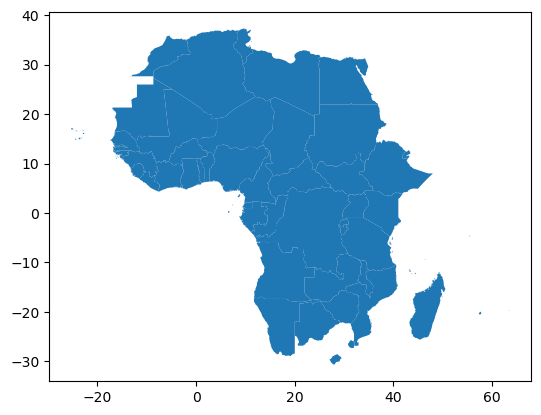

In [64]:
# then

Africa=theMapAndData[theMapAndData.region=='AFRICA']
Africa.plot()

A DDM can serve as an effective way to show the distribution of people. The most critical tasks are:

* Dot Placement: The dots should be randomly distributed within each polygon to avoid misrepresenting the data.

* Dot Unit: Deciding how many people each dot should represent is key for visual clarity. This value should be chosen carefully to avoid oversaturation or sparsity.

The size of all dots on the map must be the same to ensure a consistent visual comparison.

### Preprocessing: aggregating

This is a DOT UNIT proposal:

In [65]:
justDots=Africa.copy()
dot_value = 100000
justDots['num_dots'] = (justDots['population'] / dot_value).astype(int)

### Preprocessing: distributing dots

And here, we get a location for the dots:

In [66]:
# 2. Generate the random dot locations using .sample_points()
justDots = justDots.sample_points(size=justDots['num_dots']).explode(index_parts=True)

You get this:

In [67]:
justDots

2    0      POINT (-7.71701 27.48489)
     1      POINT (-7.62468 28.42683)
     2      POINT (-7.62122 28.94681)
     3      POINT (-7.38835 27.90115)
     4      POINT (-7.24174 29.50847)
                      ...            
168  122      POINT (34.5819 6.10977)
     123     POINT (34.63932 5.13124)
     124     POINT (34.67053 5.62539)
     125     POINT (34.82096 5.19322)
     126     POINT (35.58713 5.00488)
Name: sampled_points, Length: 14030, dtype: geometry

In [68]:
# what is it?
type(justDots)

geopandas.geoseries.GeoSeries

### Preprocessing: building GDF from GS

Notice the multi index (MI), one for a country and for a dot. As we are planing to send these points to R, we avoid MI:

In [69]:
justDots.reset_index(drop=True, inplace=True)
Africa_dots=gpd.GeoDataFrame(geometry=justDots)
Africa_dots

,geometry
0,POINT (-7.71701 27.48489)
1,POINT (-7.62468 28.42683)
2,POINT (-7.62122 28.94681)
3,POINT (-7.38835 27.90115)
4,POINT (-7.24174 29.50847)
...,...
14025,POINT (34.5819 6.10977)
14026,POINT (34.63932 5.13124)
14027,POINT (34.67053 5.62539)
14028,POINT (34.82096 5.19322)


Now you have a GDF:

In [70]:
Africa_dots.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 14030 entries, 0 to 14029
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  14030 non-null  geometry
dtypes: geometry(1)
memory usage: 109.7 KB


Juts plot the polygons as the base, and the points as the layer on top!

<Axes: >

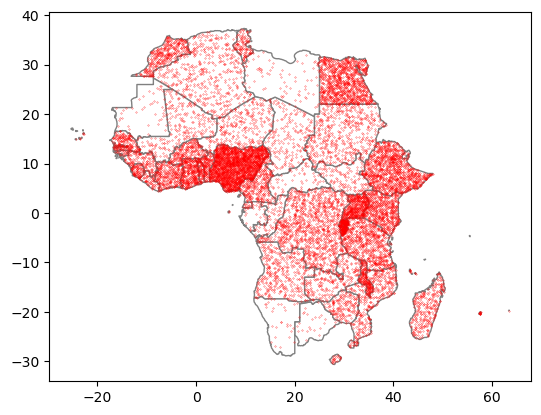

In [71]:
base=Africa.plot(facecolor="white",#color of polygon fill
               edgecolor='grey') #color of border                
Africa_dots.plot(markersize=0.05, color='red',ax=base)

It is generally recommended that DDMs use an **equal-area projection**, which benefits density and limits area distortion.

<Axes: >

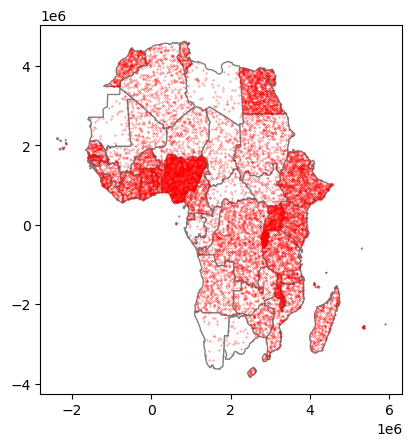

In [72]:
base=Africa.to_crs(8857).plot(facecolor="white",
                              edgecolor='grey')
Africa_dots.to_crs(8857).plot(markersize=0.05, color='red',ax=base)

Let's keep the continent countries with that crs:

In [73]:
Africa_8857=Africa.to_crs(8857)
Africa_dots_8857=Africa_dots.to_crs(8857)

# Thematics: the PSM (Proportional Symbol Map)

You have a PSM if you use a symbol (generally a circle) to show the distribution of a variable per location.
The symbol is an aggregated raw value, and its size varies according to those values. So now we need:

### Preprocessing: GDF of centroids

1. A location for a symbol, generally the polygon centroid.

In [74]:
Africa_8857_centroids = Africa_8857.copy()

# Africa_8857_centroids will have a new geometry:
Africa_8857_centroids['geometry'] = Africa_8857_centroids['geometry'].centroid

2. A size of varying values (not constant as in DDMs). Let's use population again.

In [75]:
Africa_8857_centroids['size'] = Africa_8857_centroids['population'].apply(lambda x: x**0.5/100)

## or
# import numpy as np
# Africa_8857_centroids['size'] = Africa_8857_centroids['population'].apply(lambda x: np.log10(x))

We got the basics, then:

<Axes: >

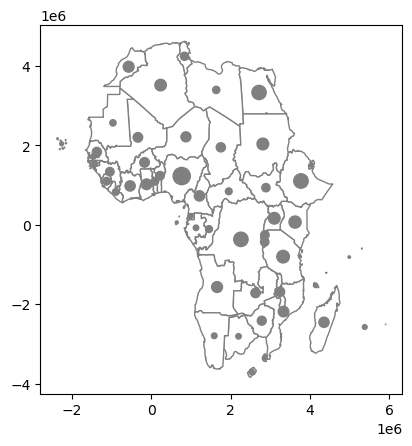

In [76]:
base=Africa_8857.plot(facecolor="white",
                      edgecolor='grey')
# Plot the centroids on top
Africa_8857_centroids.plot(
    ax=base,
    markersize=Africa_8857_centroids['size'],
    color='grey'
)

### Preprocessing: Computing new columns

PPMs are not thematic maps to see precise values, but to reveal clear differences on the variable distribution used. As, human eyes are very limited to detect area differences, we may need to use some other tactics to help uncover some patterns.

For example, let's confirm if we have outliers:

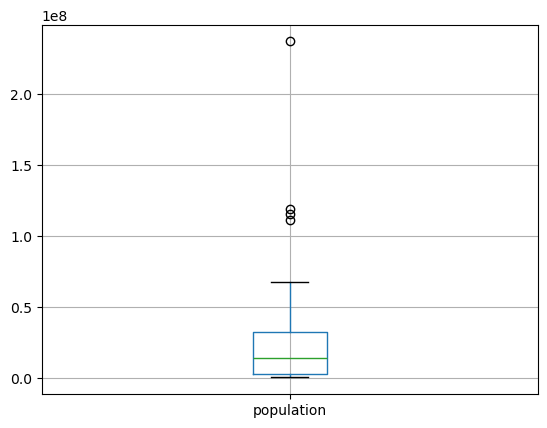

In [77]:
boxplotInfo=Africa_8857_centroids.boxplot(column='population',return_type="dict")

The object **boxplotInfo** showed the boxplot, and we confirm there are outliers. We can recover them like this:

In [78]:
outliers=boxplotInfo['fliers'][0].get_ydata()
## see
outliers

array([115403027, 111247248, 118550298, 236747130], dtype=object)

Then, these are the outlying countries:

In [79]:
Africa_8857_centroids[Africa_8857_centroids.population.isin(outliers)]

,Country,iso2,iso3,region,fragility,co2,sq_km,num_airports,population,mobiles,geometry,size
32,DEMOCRATIC REPUBLIC OF THE CONGO,CD,COD,AFRICA,110.2,2653000,2344858,273,115403027,49800000,POINT (2261167.581 -366628.064),107.425801
48,EGYPT,EG,EGY,AFRICA,88.4,235137000,1001450,73,111247248,106000000,POINT (2718439.633 3332479.727),105.473811
53,ETHIOPIA,ET,ETH,AFRICA,94.2,16798000,1104300,58,118550298,71400000,POINT (3773637.19 1103137.24),108.880805
112,NIGERIA,NG,NGA,AFRICA,98.5,104494000,923768,50,236747130,224000000,POINT (770395.209 1227428.411),153.865893


Knowing this information, we can create a column as outlier flag:

In [80]:
Africa_8857_centroids['population_outlier']=Africa_8857_centroids.population.isin(outliers)*1

## see
Africa_8857_centroids

,Country,iso2,iso3,region,fragility,co2,sq_km,num_airports,population,mobiles,geometry,size,population_outlier
2,ALGERIA,DZ,DZA,AFRICA,75.4,151633000,2381740,95,47022473,51500000,POINT (238502.141 3518510.55),68.572934,0
6,ANGOLA,AO,AGO,AFRICA,87.8,19362000,1246700,107,37202061,25700000,POINT (1660973.947 -1567698.855),60.993492,0
12,BOTSWANA,BW,BWA,AFRICA,59.5,5965000,581730,122,2450668,4440000,POINT (2201221.267 -2809166.362),15.654610,0
19,BENIN,BJ,BEN,AFRICA,73.6,6903000,112622,10,14697052,16400000,POINT (222846.461 1235558.191),38.336734,0
26,BURUNDI,BI,BDI,AFRICA,98.2,715000,27830,6,13590102,8650000,POINT (2860810.304 -431061.403),36.864756,0
29,CHAD,TD,TCD,AFRICA,108.5,1771000,1284000,44,19093595,12100000,POINT (1755417.429 1950748.319),43.696218,0
31,CONGO,CG,COG,AFRICA,92.5,4523000,342000,56,6097665,5870000,POINT (1457936.98 -107754.095),24.693451,0
32,DEMOCRATIC REPUBLIC OF THE CONGO,CD,COD,AFRICA,110.2,2653000,2344858,273,115403027,49800000,POINT (2261167.581 -366628.064),107.425801,1
35,CAMEROON,CM,CMR,AFRICA,97.0,7105000,475440,37,30966105,26200000,POINT (1217073.791 728109.574),55.647197,0
36,COMOROS,KM,COM,AFRICA,81.7,326000,2235,3,900141,934000,POINT (4141456.507 -1522508.183),9.487576,0


We can use that like this:

<Axes: >

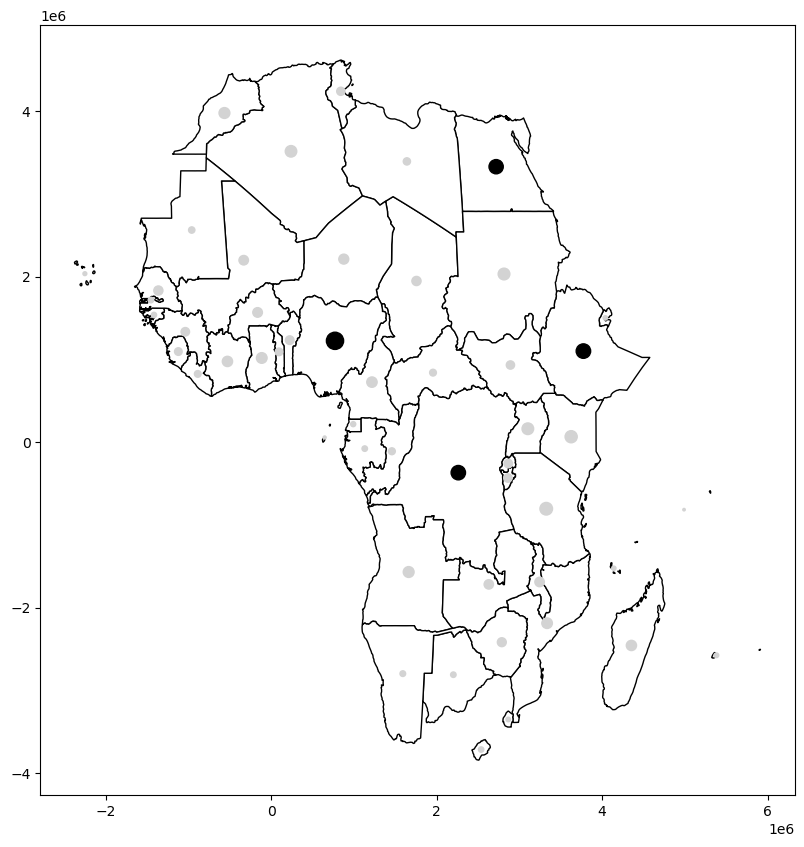

In [81]:
base = Africa_8857.plot(color='white', edgecolor='black', figsize=(10,10))

# Define your color map
mapcolor = {1: 'black', 0: 'lightgrey'}

# Plot the centroids on top
Africa_8857_centroids.plot(
    ax=base,
    markersize=Africa_8857_centroids['size'],
    color=Africa_8857_centroids['population_outlier'].map(mapcolor)
)

Here, we do a good job for outliers, but it is difficult to interprete the other ones. We could use some redundancy, but more work is needed:
1. Create two maps of centroids:

In [82]:
# Create explicit copies of the DataFrames
Africa_8857_centroids_out = Africa_8857_centroids[Africa_8857_centroids.population_outlier==1].copy()
Africa_8857_centroids_no_out = Africa_8857_centroids[Africa_8857_centroids.population_outlier==0].copy()


2. Compute sizes in each:

In [83]:
Africa_8857_centroids_out['size'] = Africa_8857_centroids_out['population'].apply(lambda x: x**0.5 / 50)
Africa_8857_centroids_no_out['size'] = Africa_8857_centroids_no_out['population'].apply(lambda x: x**0.5 / 50)

Now, plot the three layers, using some color gradient for the non-outliers:

<Axes: >

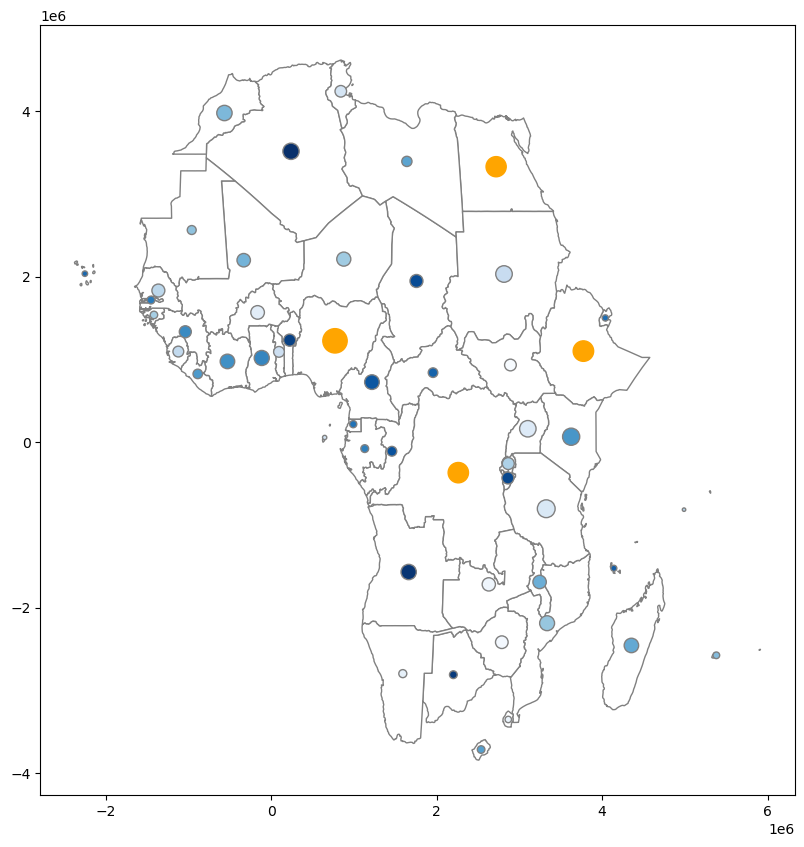

In [84]:
base=Africa_8857.plot(color='white', edgecolor='grey',figsize=(10,10)) 

Africa_8857_centroids_no_out.plot(
    ax=base,
    markersize=Africa_8857_centroids_no_out['size'],
    edgecolor='grey',
    c=Africa_8857_centroids_no_out['size'],
    cmap='Blues_r'
)
Africa_8857_centroids_out.plot(
    ax=base,
    markersize=Africa_8857_centroids_out['size'],
    color='orange'
)

# Thematics: Choropleths

Notice that the DDMs may use aggregated counts, and the PSMs use the variables in its original form. Choropleths will 'paint' the whole polygon and as noticed in PSMs, we have to be very careful when using color in shape, as the area itself is a confounding. To control this visual artifact, the variable must be normalized, that is, divided by a value correlated with the area. 

Then, for this course, a choropleth is a normalized representation of data.

Following our definition:

* This is **NOT** a choropleth:


<Axes: >

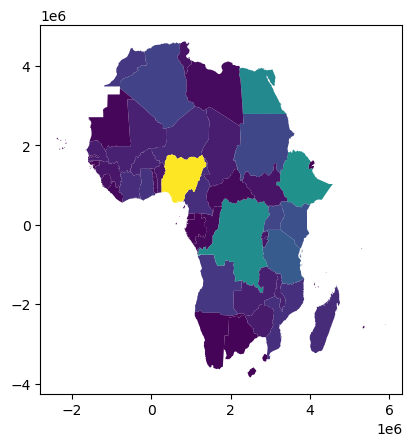

In [85]:
Africa_8857.plot(Africa_8857.population)

* * This **IS** a choropleth:

<Axes: >

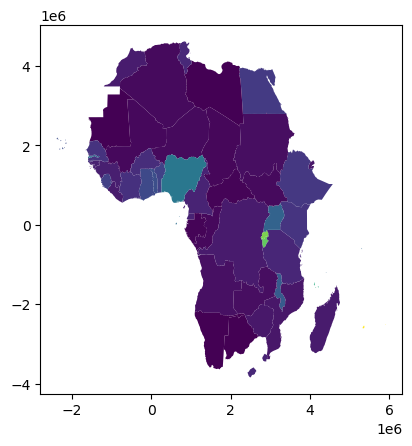

In [86]:
Africa_8857.plot(Africa_8857.population/Africa_8857.sq_km)

Choropleths are great to represent normalized indicators such as:
* Densities
* Ratios
* Rates
* Averages

Population by area is a density indicator. This is a real number (not an integer), so most of the time the color gradient might  not be 
that useful to reveal some pattern visually. Then, we often discretize (or bin) the indicator computed.

### Preprocessing: Discretizing

Now, we want to cut the variable. Run the next code to make sure you have tose packages:

In [87]:
## do you have these installed?
# ! pip show numba mapclassify numpy

We will discretize this:

In [88]:
Africa_8857['population_density']=Africa_8857.population/Africa_8857.sq_km

Let's explore the bining algorithms:

In [89]:
import mapclassify
import numpy as np

np.random.seed(12345) # so we all get the same results!

# let's try 5 intervals
K=5
theVar=Africa_8857['population_density']
# same interval width, easy interpretation
ei5 = mapclassify.EqualInterval(theVar, k=K)
# same interval width based on standard deviation, easy - but not as the previous one, poor when high skewness
msd = mapclassify.StdMean(theVar)
# interval width varies, counts per interval are close, not easy to grasp, repeated values complicate cuts
q5=mapclassify.Quantiles(theVar,k=K)

# based on similarity, good for multimodal data
mb5 = mapclassify.MaximumBreaks(theVar, k=K)
# based on similarity, good for skewed data
ht = mapclassify.HeadTailBreaks(theVar) # no K needed
# based on similarity, optimizer
fj5 = mapclassify.FisherJenks(theVar, k=K)
# based on similarity, optimizer
jc5 = mapclassify.JenksCaspall(theVar, k=K)
# based on similarity, optimizer
mp5 = mapclassify.MaxP(theVar, k=K)

How can we select the right classification?
Let me use the the Absolute deviation around class median (ADCM) to make the comparisson:

In [90]:
class5 = ei5,msd, q5,mb5,  ht, fj5, jc5, mp5
# Collect ADCM for each classifier
fits = np.array([ c.adcm for c in class5])
# Convert ADCM scores to a DataFrame
adcms = pd.DataFrame(fits)
# Add classifier names
adcms['classifier'] = [c.name for c in class5]
# Add column names to the ADCM
adcms.columns = ['ADCM', 'Classifier']

Now, plot the **adcms**:

<Axes: ylabel='Classifier'>

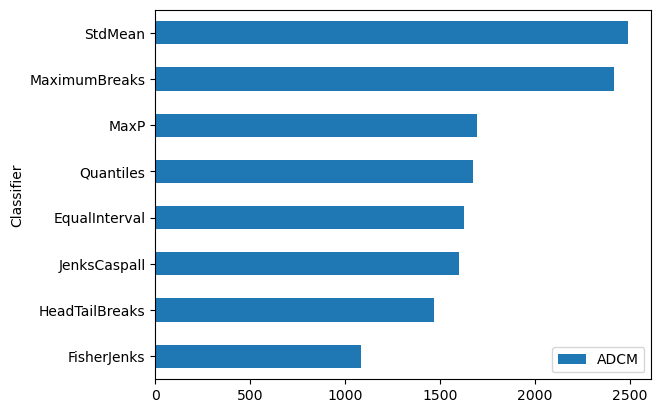

In [91]:
adcms.sort_values('ADCM').plot.barh(x='Classifier')

Let's save the best strategy:

In [92]:
Africa_8857['population_density_FJ5'] = fj5.yb

In [93]:
# there you are
Africa_8857[['population_density','population_density_FJ5']].head(20)

,population_density,population_density_FJ5
2,19.742908,0
6,29.840428,0
12,4.212724,0
19,130.498943,1
26,488.325620,3
29,14.870401,0
31,17.829430,0
32,49.215358,0
35,65.131468,0
36,402.747651,3


We could create a copy of the bins to add labels:

In [94]:
# renaming
newLabelsForLevels={0:"0_VeryLow", 1:"1_Low", 2:"2_Middle", 3:"3_High", 4:"4_VeryHigh"}

Africa_8857['population_density_FJ5_cat']=Africa_8857.loc[:,'population_density_FJ5'].replace(newLabelsForLevels)

# we have
Africa_8857[['population_density','population_density_FJ5','population_density_FJ5_cat']].head(20)

,population_density,population_density_FJ5,population_density_FJ5_cat
2,19.742908,0,0_VeryLow
6,29.840428,0,0_VeryLow
12,4.212724,0,0_VeryLow
19,130.498943,1,1_Low
26,488.325620,3,3_High
29,14.870401,0,0_VeryLow
31,17.829430,0,0_VeryLow
32,49.215358,0,0_VeryLow
35,65.131468,0,0_VeryLow
36,402.747651,3,3_High


We are ready for a discrete choropleth:

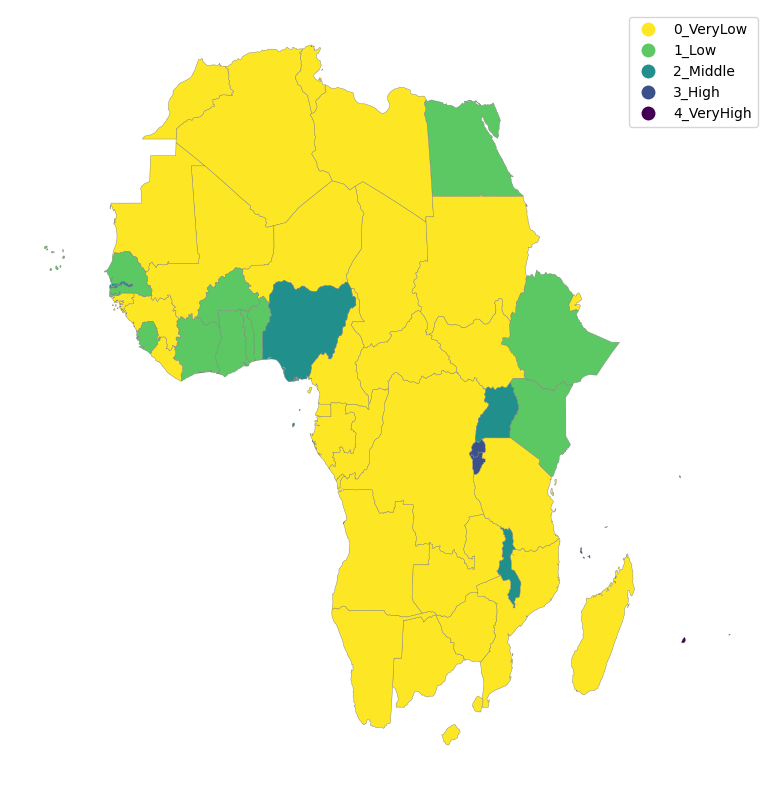

In [95]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, figsize=(10, 10))
Africa_8857.plot(column='population_density_FJ5_cat', # variable to plot
                 cmap='viridis_r', # set of colors
                 categorical=True, # can be interpreted as category
                 edgecolor='grey', # border color
                 linewidth=0.3, # width of border
                 legend=True, # need a legend?                   
                 ax=ax
       )

ax.set_axis_off()

# Saving

Let's save this maps for R.

In [96]:
## Good practice to refresh your memory

## Find only GeoDataFrames in the current session
geodataframe_list = [var for var in globals() if isinstance(globals()[var], gpd.GeoDataFrame)]

print("List of GeoDataFrames in memory:")
for name in geodataframe_list:
    print(name)

List of GeoDataFrames in memory:
countries
_4
theMapAndData
_11
Africa
Africa_dots
_21
Africa_8857
Africa_dots_8857
Africa_8857_centroids
_31
_32
Africa_8857_centroids_out
Africa_8857_centroids_no_out
_59
_69
_79
_80


These are the ones needed in R:

In [97]:
# for choropleth and base map
Africa_8857.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 51 entries, 2 to 168
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Country                     51 non-null     object  
 1   iso2                        50 non-null     object  
 2   iso3                        51 non-null     object  
 3   region                      51 non-null     object  
 4   fragility                   51 non-null     float64 
 5   co2                         51 non-null     int64   
 6   sq_km                       51 non-null     int32   
 7   num_airports                51 non-null     int32   
 8   population                  51 non-null     int32   
 9   mobiles                     51 non-null     int32   
 10  geometry                    51 non-null     geometry
 11  population_density          51 non-null     float64 
 12  population_density_FJ5      51 non-null     int64   
 13  population_density

In [98]:
# for DDMs
Africa_dots_8857.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 14030 entries, 0 to 14029
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  14030 non-null  geometry
dtypes: geometry(1)
memory usage: 109.7 KB


In [99]:
# for PSMs
Africa_8857_centroids.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 51 entries, 2 to 168
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Country             51 non-null     object  
 1   iso2                50 non-null     object  
 2   iso3                51 non-null     object  
 3   region              51 non-null     object  
 4   fragility           51 non-null     float64 
 5   co2                 51 non-null     int64   
 6   sq_km               51 non-null     int32   
 7   num_airports        51 non-null     int32   
 8   population          51 non-null     int32   
 9   mobiles             51 non-null     int32   
 10  geometry            51 non-null     geometry
 11  size                51 non-null     float64 
 12  population_outlier  51 non-null     int64   
dtypes: float64(2), geometry(1), int32(4), int64(2), object(4)
memory usage: 4.8+ KB


In [100]:
# for PSMs
Africa_8857_centroids_out.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4 entries, 32 to 112
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Country             4 non-null      object  
 1   iso2                4 non-null      object  
 2   iso3                4 non-null      object  
 3   region              4 non-null      object  
 4   fragility           4 non-null      float64 
 5   co2                 4 non-null      int64   
 6   sq_km               4 non-null      int32   
 7   num_airports        4 non-null      int32   
 8   population          4 non-null      int32   
 9   mobiles             4 non-null      int32   
 10  geometry            4 non-null      geometry
 11  size                4 non-null      float64 
 12  population_outlier  4 non-null      int64   
dtypes: float64(2), geometry(1), int32(4), int64(2), object(4)
memory usage: 384.0+ bytes


In [101]:
# for PSMs
Africa_8857_centroids_no_out.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 47 entries, 2 to 168
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Country             47 non-null     object  
 1   iso2                46 non-null     object  
 2   iso3                47 non-null     object  
 3   region              47 non-null     object  
 4   fragility           47 non-null     float64 
 5   co2                 47 non-null     int64   
 6   sq_km               47 non-null     int32   
 7   num_airports        47 non-null     int32   
 8   population          47 non-null     int32   
 9   mobiles             47 non-null     int32   
 10  geometry            47 non-null     geometry
 11  size                47 non-null     float64 
 12  population_outlier  47 non-null     int64   
dtypes: float64(2), geometry(1), int32(4), int64(2), object(4)
memory usage: 4.4+ KB


The file **africa_8857.gpkg** will keep all those maps as layers!

In [102]:
Africa_8857.to_file("africa_8857.gpkg",driver='GPKG',layer='continent')
Africa_dots_8857.to_file("africa_8857.gpkg",driver='GPKG',layer='population_ddm')
Africa_8857_centroids.to_file("africa_8857.gpkg",driver='GPKG',layer='population_psm')
Africa_8857_centroids_out.to_file("africa_8857.gpkg",driver='GPKG',layer='outlier_population_psm')
Africa_8857_centroids_no_out.to_file("africa_8857.gpkg",driver='GPKG',layer='no_outlier_population_psm')